# Regression for Bike Data

1. Pipeline <br>
1.1. Train-validation-test split <br>
1.2. MaxAbsScaler <br>
1.3. Gradient Boosting Regressor <br>
1.4. GridSearchCV
2. Metrics (Normalized RMSE)
3. Visualization (plt)
4. Forecasting

## Model

### Preparation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer

In [5]:
# import data from csv
df = pd.read_csv("daily-bike-share.csv")
df.head()

,day,mnth,year,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1,2011,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1,2011,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1,2011,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1,2011,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1,2011,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82


In [6]:
# split features and label
X = df.drop(columns="rentals")
y = df[["rentals"]]

X.head()
y.head()

,rentals
0,331
1,131
2,120
3,108
4,82


#### Train-validation-test split

In [7]:
# train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42)

### Pipeline

In [8]:
# create pipeline
pipeline = Pipeline([
    ("scaler", MaxAbsScaler()),
    ("gbm", GradientBoostingRegressor(random_state=42,
     n_iter_no_change=5, validation_fraction=0.2))
])

#### Normalized RMSE

In [9]:
def calculate_nrmse(y_true, y_pred, normalization_factor=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    if normalization_factor is None:
        normalization_factor = np.max(y_true) - np.min(y_true)

    nrmse = rmse / normalization_factor
    return nrmse


# Normalization factor (choose one)
normalization_factor = np.max(y_val) - np.min(y_val)  # Range
# normalization_factor = np.mean(y_val)  # Mean
# normalization_factor = np.std(y_val)  # Standard deviation

In [10]:
# set up custom scorer
nrmse_scorer = make_scorer(
    calculate_nrmse, greater_is_better=False, normalization_factor=normalization_factor)

#### GridSearchCV

In [11]:
# Define the hyperparameter grid for GBM
param_grid = {
    "gbm__n_estimators": [20, 50, 100],  # Number of boosting stages
    "gbm__learning_rate": [0.01, 0.1, 0.25],  # Learning rate
    "gbm__max_depth": [3, 5, 7],  # Maximum depth of the individual estimators
    # Minimum number of samples required to split a node
    "gbm__min_samples_split": [2, 5, 10],
    # Minimum number of samples required at a leaf node
    "gbm__min_samples_leaf": [1, 2, 4],
    # Number of features to consider for the best split
    "gbm__max_features": ["sqrt", "log2"]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=nrmse_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

#### Training model

In [12]:
# train data
grid_search.fit(X_train, y_train.squeeze())

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MaxAbsScaler()),
                                       ('gbm',
                                        GradientBoostingRegressor(n_iter_no_change=5,
                                                                  random_state=42,
                                                                  validation_fraction=0.2))]),
             n_jobs=-1,
             param_grid={'gbm__learning_rate': [0.01, 0.1, 0.25],
                         'gbm__max_depth': [3, 5, 7],
                         'gbm__max_features': ['sqrt', 'log2'],
                         'gbm__min_samples_leaf': [1, 2, 4],
                         'gbm__min_samples_split': [2, 5, 10],
                         'gbm__n_estimators': [20, 50, 100]},
             scoring=make_scorer(calculate_nrmse, greater_is_better=False, normalization_factor=2825),
             verbose=1)

#### Validating model

In [13]:
# get best params
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Params: {best_params}')
print(f'Best Cross Validation Score (Negative RMSE): {best_score:.4f}')

Best Params: {'gbm__learning_rate': 0.1, 'gbm__max_depth': 7, 'gbm__max_features': 'sqrt', 'gbm__min_samples_leaf': 4, 'gbm__min_samples_split': 2, 'gbm__n_estimators': 100}
Best Cross Validation Score (Negative RMSE): -0.1031


In [14]:
# make prediction on the validation set using the best model
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

# calculate the nrmse
nrmse_val = calculate_nrmse(
    y_true=y_val, y_pred=y_val_pred, normalization_factor=normalization_factor)
print(f'Validation NRMSE: {nrmse_val:.4f}')

# Early stopping: Check if NRMSE is below 8.5%
if nrmse_val < 0.085:
    print("Stopping training: NRMSE is below 8.5%.")
else:
    print("NRMSE is above 8.5%. Consider further tuning or training.")

Validation NRMSE: 0.0857
NRMSE is above 8.5%. Consider further tuning or training.


In [15]:
# Make predictions on the test set using the best model
y_test_pred = best_model.predict(X_test)

# Calculate NRMSE on the test set
nrmse_test = calculate_nrmse(y_test, y_test_pred, normalization_factor)
print(f"Test Set NRMSE: {nrmse_test:.4f}")

# Print final evaluation
print("\nFinal Evaluation:")
print(f"Validation NRMSE: {nrmse_val:.4f}")
print(f"Test Set NRMSE: {nrmse_test:.4f}")

Test Set NRMSE: 0.0715

Final Evaluation:
Validation NRMSE: 0.0857
Test Set NRMSE: 0.0715


## Visualization

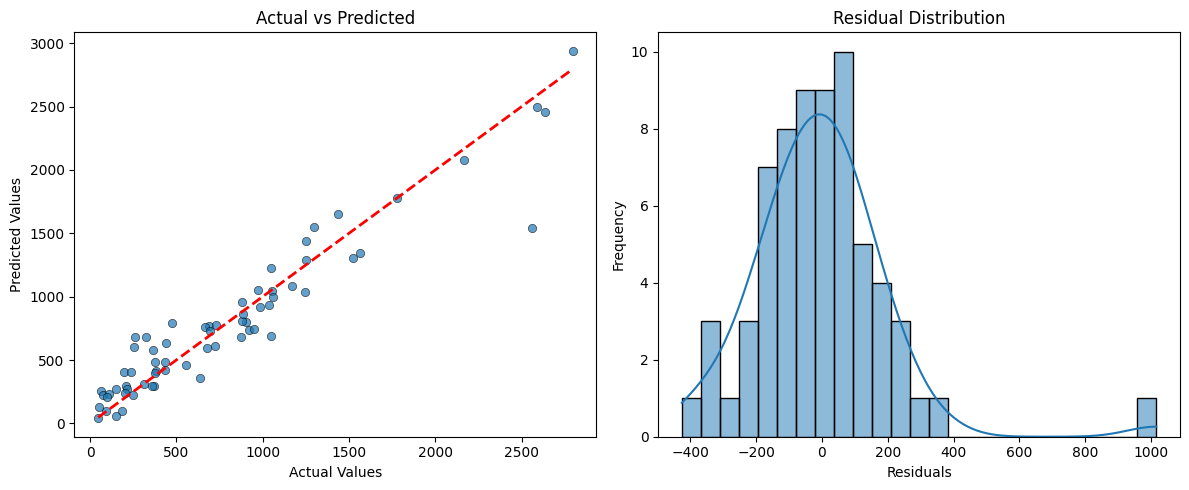

In [16]:
# Visualization
plt.figure(figsize=(12, 5))

y_vis = y_test.squeeze()

# Actual vs Predicted plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_vis, y=y_test_pred, alpha=0.7, edgecolor='k')
plt.plot([y_vis.min(), y_vis.max()], [
         y_vis.min(), y_vis.max()], '--r', linewidth=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")

# Residual Plot
plt.subplot(1, 2, 2)
residuals = y_vis - y_test_pred
sns.histplot(residuals, bins=25, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()

## Forecasting new data

In [18]:
import json

# new json data
json_data = '''
   {
  "input_data": {
    "columns": [
      "day",
      "mnth",
      "year",
      "season",
      "holiday",
      "weekday",
      "workingday",
      "weathersit",
      "temp",
      "atemp",
      "hum",
      "windspeed"
    ],
    "index": [0],
    "data": [[1,1,2022,2,0,1,1,2,0.3,0.3,0.3,0.3]]
  }
 }
'''

data = json.loads(json_data)

In [ ]:
# converting JSON data into dataframe
columns = data["input_data"]["columns"]
rows = data["input_data"]["data"]

new_data = pd.DataFrame(rows, columns=columns)
new_data

,day,mnth,year,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,2022,2,0,1,1,2,0.3,0.3,0.3,0.3


In [22]:
# predicting new data
prediction = grid_search.predict(new_data)
prediction

array([349.97764897])